In [295]:
# importing libraries
import csv
import numpy as np
import pandas as pd

In [296]:
colnames = ['User', 'church_avg', 'resort_avg', 'beach_avg', 'park_avg', 'theater_avg',
       'museum_avg', 'mall_avg', 'zoo_avg', 'restaurants_avg', 'bars_avg',
       'local_services_avg', 'burger_pizza_avg', 'hotel_avg', 'juice_avg',
       'art_avg', 'dance_avg', 'pool_avg', 'gym_avg', 'bakery_avg',
       'beauty_avg', 'spa_avg', 'cafe_avg', 'viewpoint_avg', 'monument_avg',
       'garden_avg']

In [297]:
data = pd.read_csv('google_review_ratings.csv')
data.columns = colnames
data = data.drop("User", axis=1)
data = data.fillna(0.0)

In [298]:
x: pd.array
problem_idx = 0

for i in range(0, len(data["local_services_avg"])-1):
    try:
        x[i] = float(data.local_services_avg[i])
    except:
        #print(i)
        print(data["local_services_avg"][i])
        problem_idx = i

# our best guess for what this value should be is 2.2
data["local_services_avg"][problem_idx] = 2.2
print(problem_idx)

2	2.
2712


/var/folders/nw/5zcrqdxs7c57b12ptv8284p80000gn/T/ipykernel_2579/435481616.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = float(data.local_services_avg[i])
/var/folders/nw/5zcrqdxs7c57b12ptv8284p80000gn/T/ipykernel_2579/435481616.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = float(data.local_services_avg[i])
/var/folders/nw/5zcrqdxs7c57b12ptv8284p80000gn/T/ipykernel_2579/435481616.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

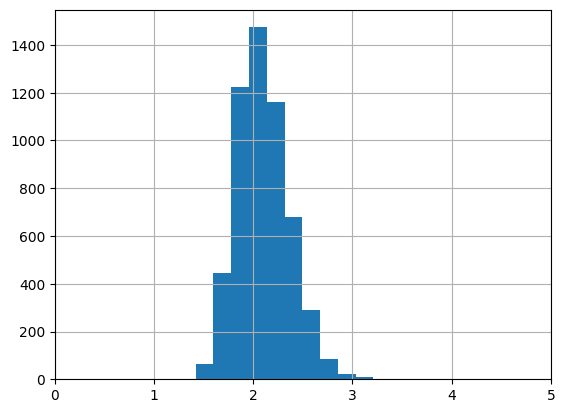

In [299]:
import matplotlib.pyplot as plt

data["user_average"] = data.apply(lambda row: row[row.apply(lambda x: isinstance(x, (int, float))) & (row != 0)].mean(), axis=1)
data["user_average"].hist()
plt.xlim(0, 5)
plt.show()


In [300]:
data["skew"] = data["user_average"] - 2.5

In [301]:
unskew = data
x = unskew["skew"]
unskew = unskew.drop("skew", axis=1)
unskew["skew"] = x # get rid of initial mean function


In [302]:
unskew = unskew.apply(lambda row: row[row.apply # subtracts skew from non-zero values
                             (lambda y: isinstance(y, (int, float)))
                             & (row != 0)] 
                             - x, 
                             axis=0)
unskew = unskew.fillna(0)

In [303]:
unskew = unskew.drop(labels=["user_average"], axis=1)
unskew["user_average"] = unskew.apply(lambda row: row[row.apply(
    lambda x: isinstance(x, (int, float))) 
    & (row != 0)].mean(), # creates new user average
    axis=1)

In [304]:
z = data.apply(lambda col: col[col.apply(lambda x: isinstance(x, (int, float))) & (col != 0)].mean(), axis= 0).to_dict()
y = unskew.apply(lambda col: col[col.apply(lambda x: isinstance(x, (int, float))) & (col != 0)].mean(), axis= 0).to_dict()

print(z)
print(y)

{'church_avg': 1.5096768675156813, 'resort_avg': 2.358613492359299, 'beach_avg': 2.4911573734409393, 'park_avg': 2.7968859970674487, 'theater_avg': 2.958940615835777, 'museum_avg': 2.8934897360703813, 'mall_avg': 3.3513947947214073, 'zoo_avg': 2.5407954545454543, 'restaurants_avg': 3.1260190615835772, 'bars_avg': 2.8327291055718473, 'local_services_avg': 2.2, 'burger_pizza_avg': 2.078339138405133, 'hotel_avg': 2.1255113636363636, 'juice_avg': 2.1908614369501467, 'art_avg': 2.208191489361702, 'dance_avg': 1.2177994011976048, 'pool_avg': 1.0405565601768134, 'gym_avg': 1.0108335210633026, 'bakery_avg': 1.1998390022675738, 'beauty_avg': 1.196576754385965, 'spa_avg': 1.0860696619950536, 'cafe_avg': 1.8687008413226376, 'viewpoint_avg': 1.6211893674815678, 'monument_avg': 1.627900573613767, 'garden_avg': 1.81, 'user_average': 2.1000332281039427, 'skew': -0.40004009302747773}
{'church_avg': 1.917031479577524, 'resort_avg': 2.763634344105745, 'beach_avg': 2.8913359698211467, 'park_avg': 3.19685